In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive

In [3]:
drive.mount('drive')

Mounted at drive


In [4]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/goldarchive/monthly_csv.csv")

In [5]:
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [6]:
df.shape

(847, 2)

In [7]:
print(f"Date range of gold prices from {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

Date range of gold prices from 1950-01 to 2020-07


In [8]:
date = pd.date_range(start='1/1/1950', end='8/1/2020', freq='M')

In [9]:
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [10]:
df['month'] = date
df.drop('Date', axis=1, inplace=True)
df = df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


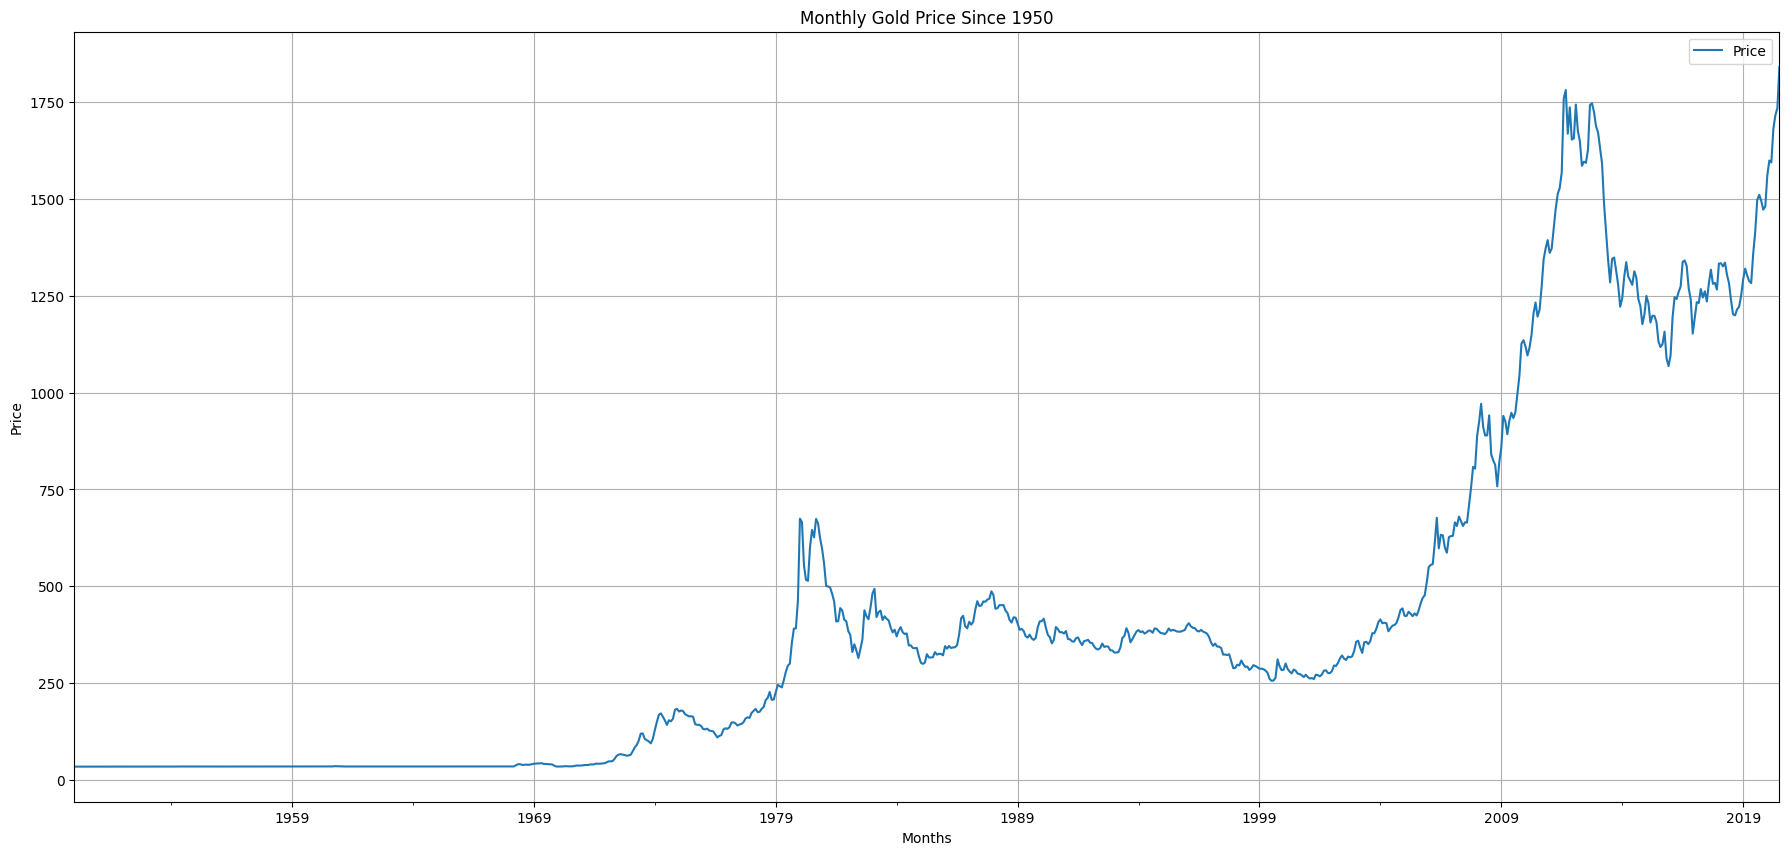

In [11]:
df.plot(figsize=(22,10))
plt.title("Monthly Gold Price Since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid()

In [12]:
round(df.describe(), 3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


In [13]:
# AVG gold price in the last 70 years = $416.56
# 25% of the time gold price = $447.07
# Highest gold price = $1840.81

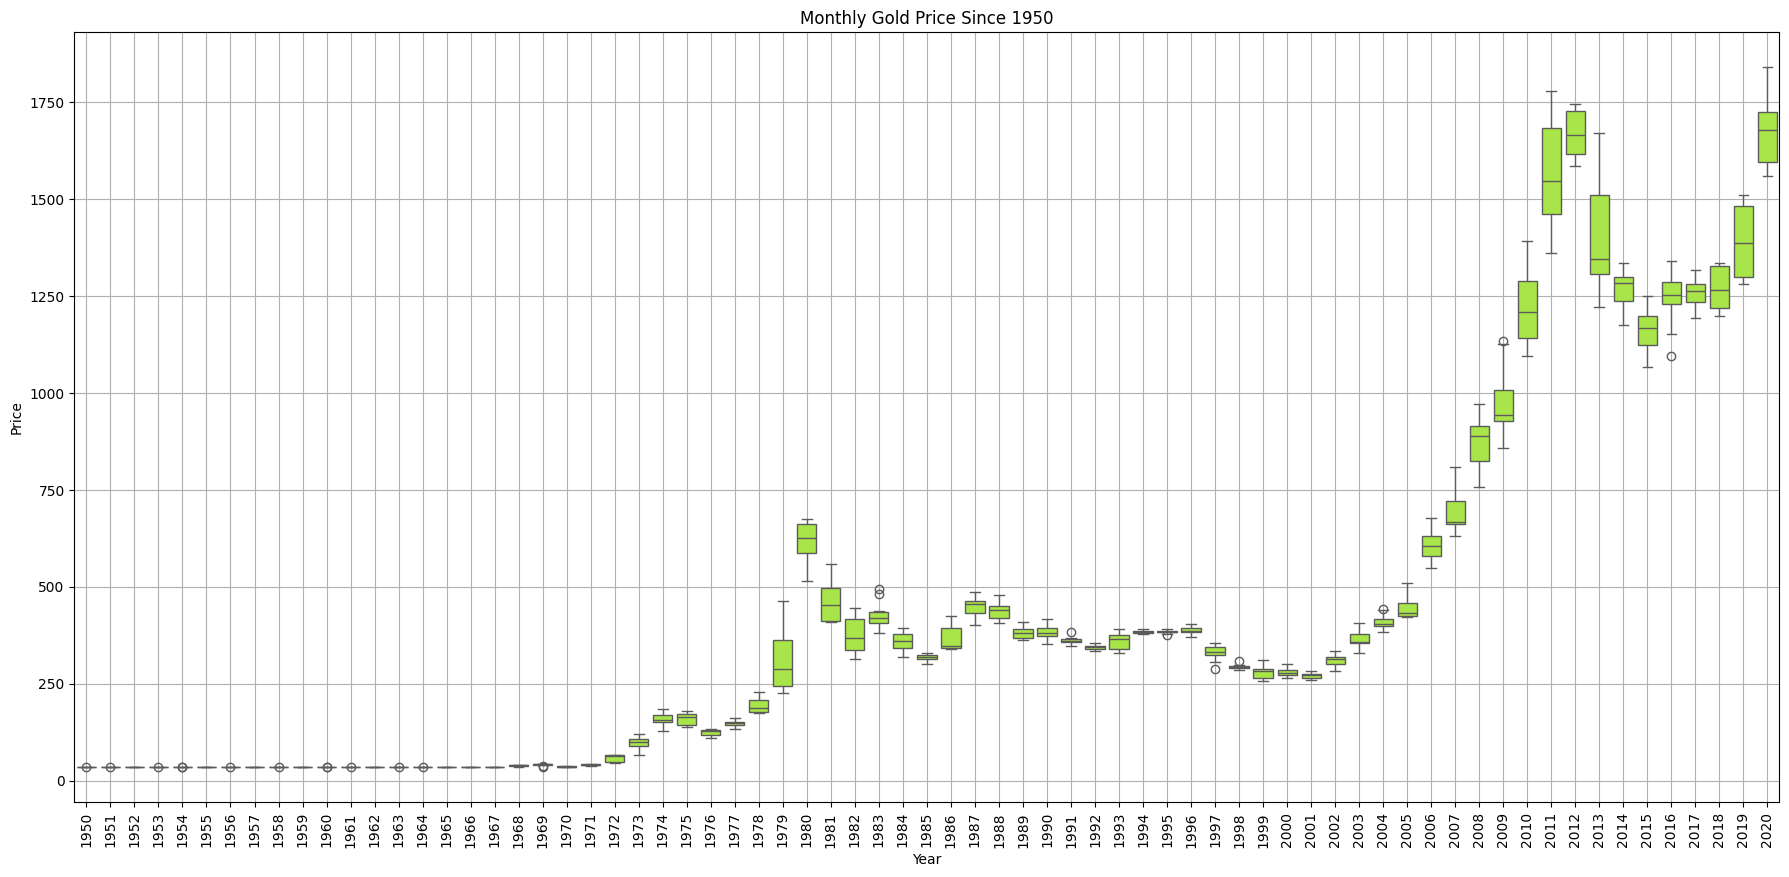

In [14]:
_, ax = plt.subplots(figsize=(22, 10))
sns.boxplot(x = df.index.year, y = df.values[:,0], ax=ax, color = "greenyellow")
plt.title("Monthly Gold Price Since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.xticks(rotation=90)
plt.grid()

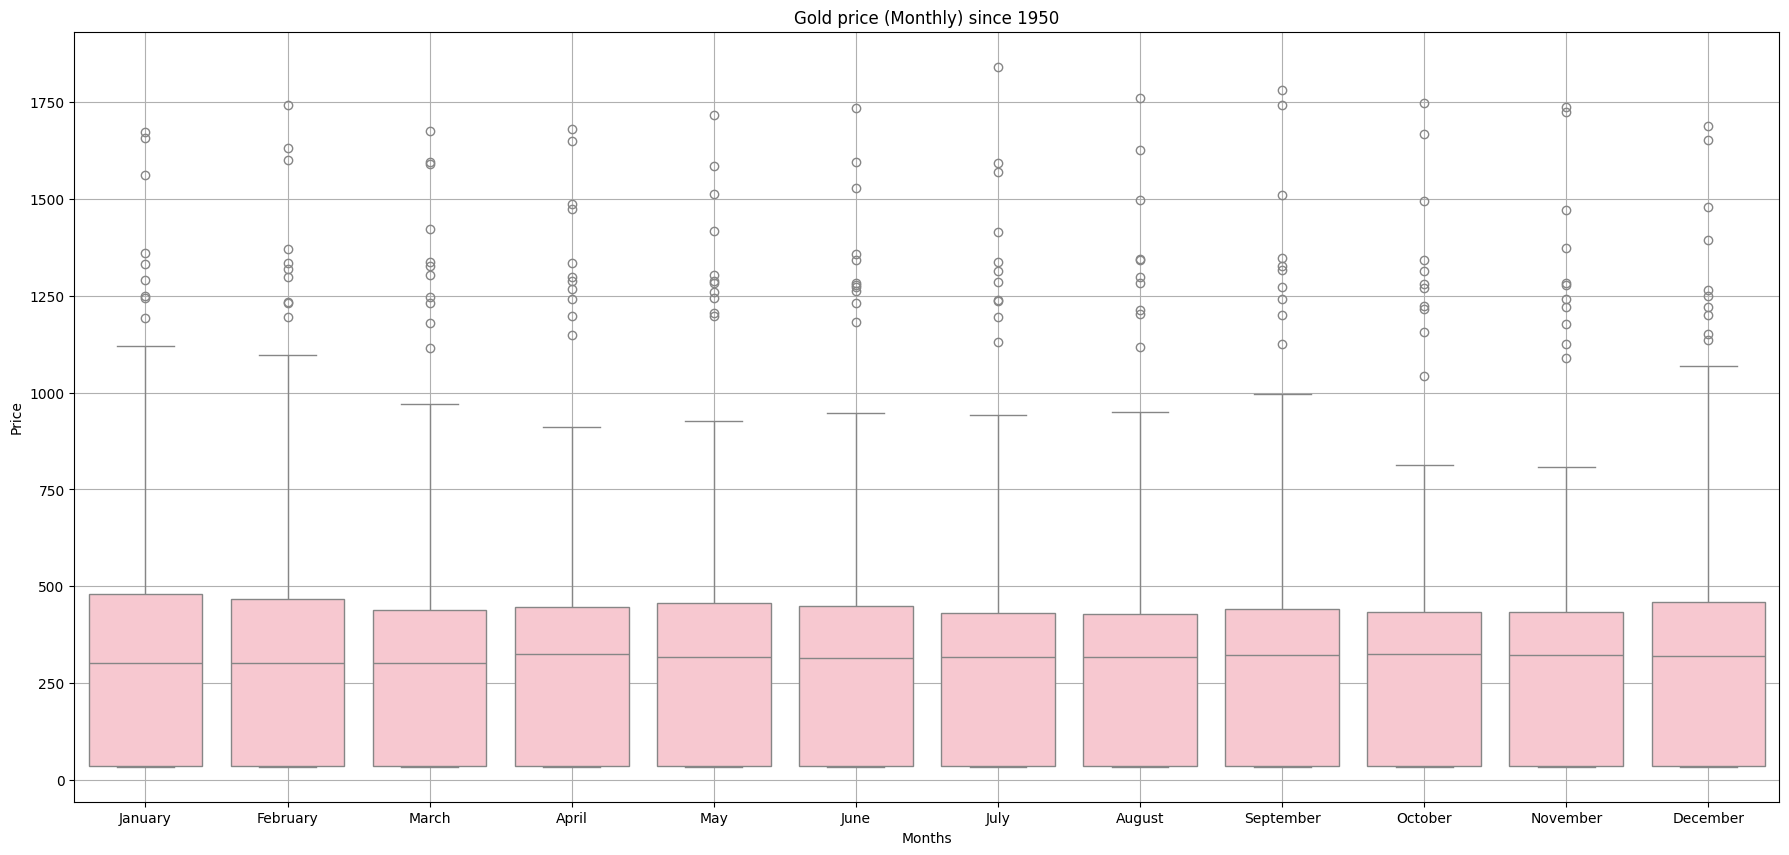

In [15]:
import seaborn as sns

_, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x = df.index.month_name(),y = df.values[:,0],ax=ax, color = "pink")
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid()

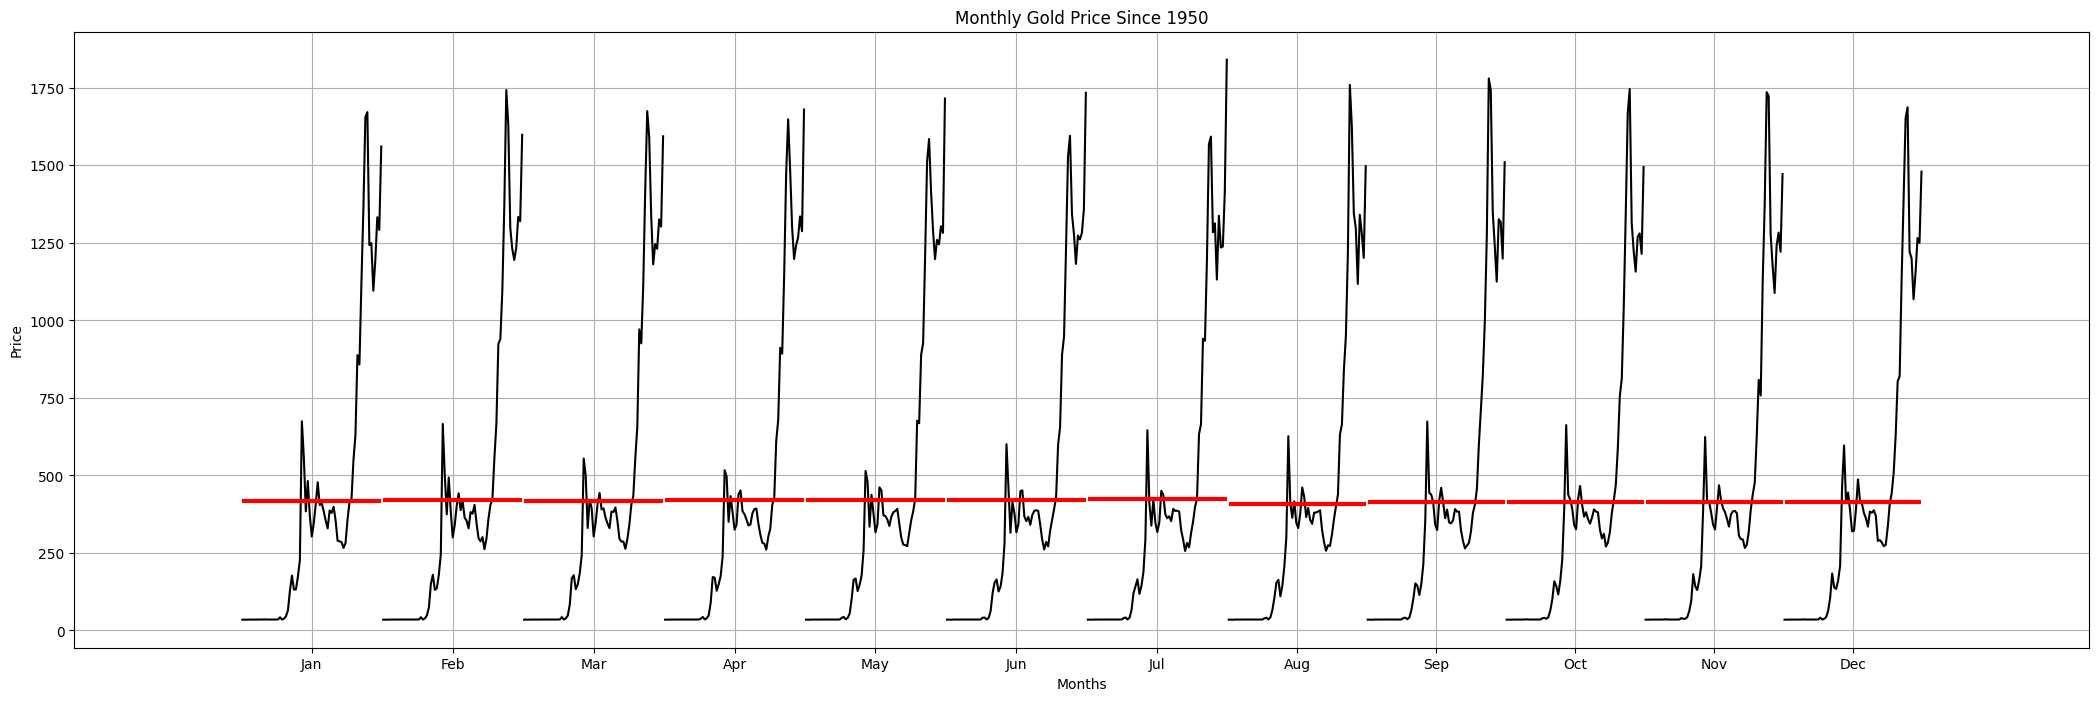

In [16]:
from statsmodels.graphics.tsaplots import month_plot
fig, ax = plt.subplots(figsize = (26,8))

month_plot(df, ylabel='Gold Price', ax=ax)
plt.title("Monthly Gold Price Since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid()

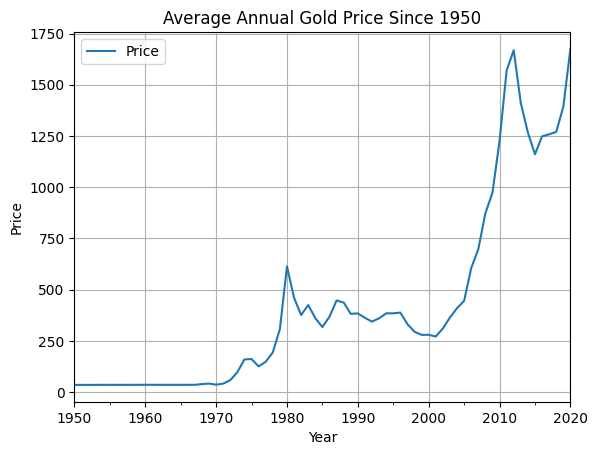

In [17]:
# Trend since 1950 : avg. annual gold price
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot();
plt.title("Average Annual Gold Price Since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.grid()

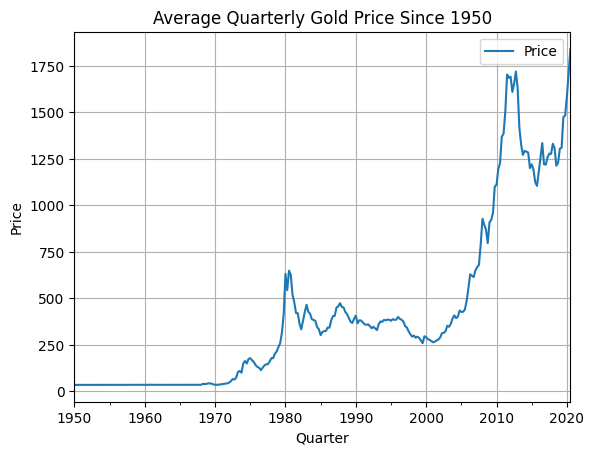

In [18]:
# Trend since 1950 : avg. quarterly gold price
df_quarterly_sum = df.resample('Q').mean()
df_quarterly_sum.plot();
plt.title("Average Quarterly Gold Price Since 1950")
plt.xlabel("Quarter")
plt.ylabel("Price")
plt.grid()

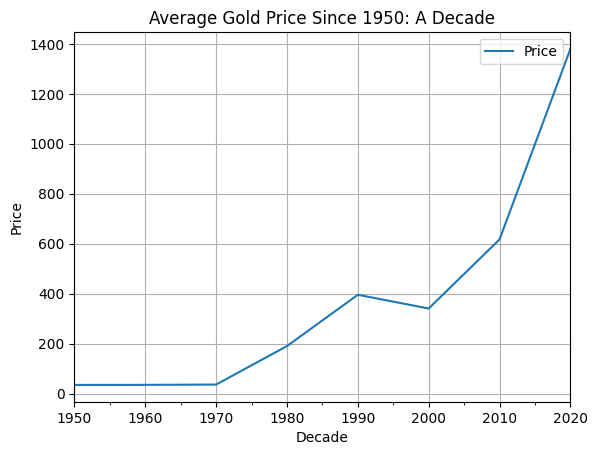

In [19]:
# Average gold price (decade) trend since 1950
df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot();
plt.title("Average Gold Price Since 1950: A Decade")
plt.xlabel("Decade")
plt.ylabel("Price")
plt.grid()

In [20]:
# Coefficient of variation: dispersion of data points in a data series around the mean.
# -> to determine volatility, or risk, is assumed in comparison to the amount of return expected from investments.
# -> lower ratio of the standard deviation to mean return, the better risk-return trade-off.

In [21]:
# price coefficient of variation
df_a = df.groupby(df.index.year).mean().rename(columns={'Price':'Mean'})
df_a = df_a.merge(df.groupby(df.index.year).std().rename(columns={'Price':'Std'}),left_index=True,right_index=True)
df_a['CoVar'] = ((df_a['Std']/df_a['Mean'])*100).round(2)
df_a.head()

,Mean,Std,CoVar
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


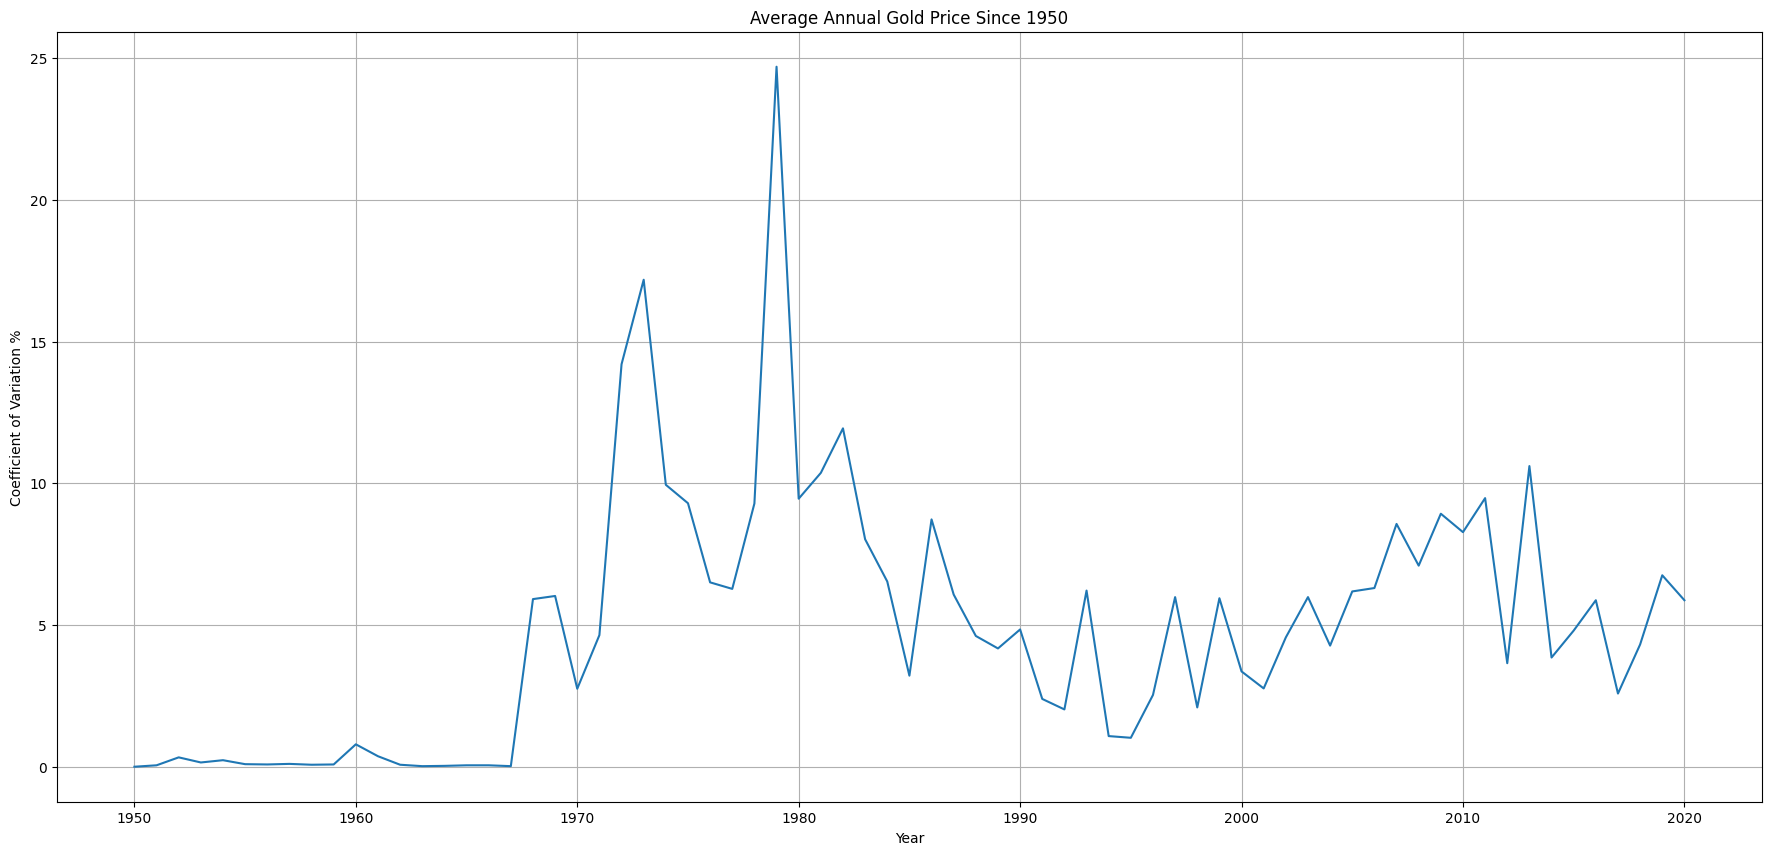

In [22]:
fix, ax = plt.subplots(figsize=(22,10))
df_a['CoVar'].plot();
plt.title("Average Annual Gold Price Since 1950")
plt.xlabel("Year")
plt.ylabel("Coefficient of Variation %")
plt.grid()

In [23]:
train = df[df.index.year <= 2015]
test = df[df.index.year > 2015]

In [24]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


In [25]:
#Linear regression
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time), len(test_time)

(792, 55)

In [26]:
lin_train = train.copy()
lin_test = test.copy()

In [27]:
lin_train['time'] = train_time
lin_test['time'] = test_time

In [28]:
lin = LinearRegression()
lin.fit(lin_train[['time']], lin_train['Price'].values)

LinearRegression()

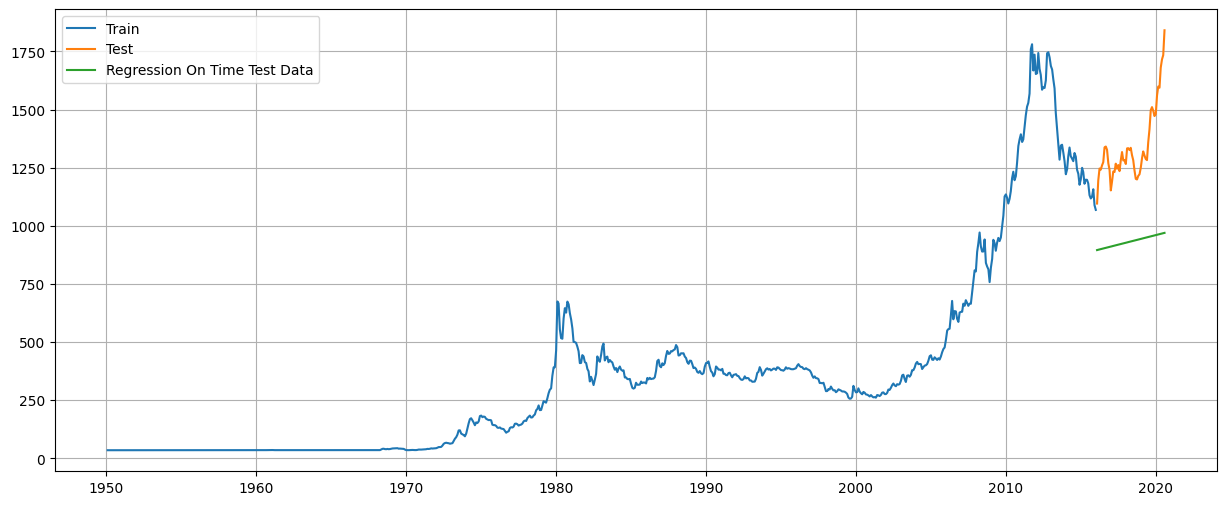

In [29]:
test_predictions_model1 = lin.predict(lin_test[['time']])
lin_test['forecast'] = test_predictions_model1

plt.figure(figsize=(15,6))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(lin_test['forecast'], label='Regression On Time Test Data')
plt.legend(loc='best')
plt.grid()

In [30]:
# MAPE: Mean absolute percentage error
def mape(actual, pred):
  return round((np.mean(abs(actual-pred)/actual))*100,2)

In [31]:
# MAPE
model1_mape_test = mape(test['Price'].values, test_predictions_model1)
print("RegressionOnTime Forecast on Test Data, MAPE = %3.3f" %(model1_mape_test), "%")

RegressionOnTime Forecast on Test Data, MAPE = 29.760 %


In [32]:
results = pd.DataFrame({'Test MAPE %': [model1_mape_test]}, index=["RegressionOnTime"])
results

,Test MAPE %
RegressionOnTime,29.76


In [33]:
# Naive
naive_train = train.copy()
naive_test = test.copy()

In [34]:
naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
naive_test['naive'].head()

,naive
month,
2016-01-31,1068.317
2016-02-29,1068.317
2016-03-31,1068.317
2016-04-30,1068.317
2016-05-31,1068.317


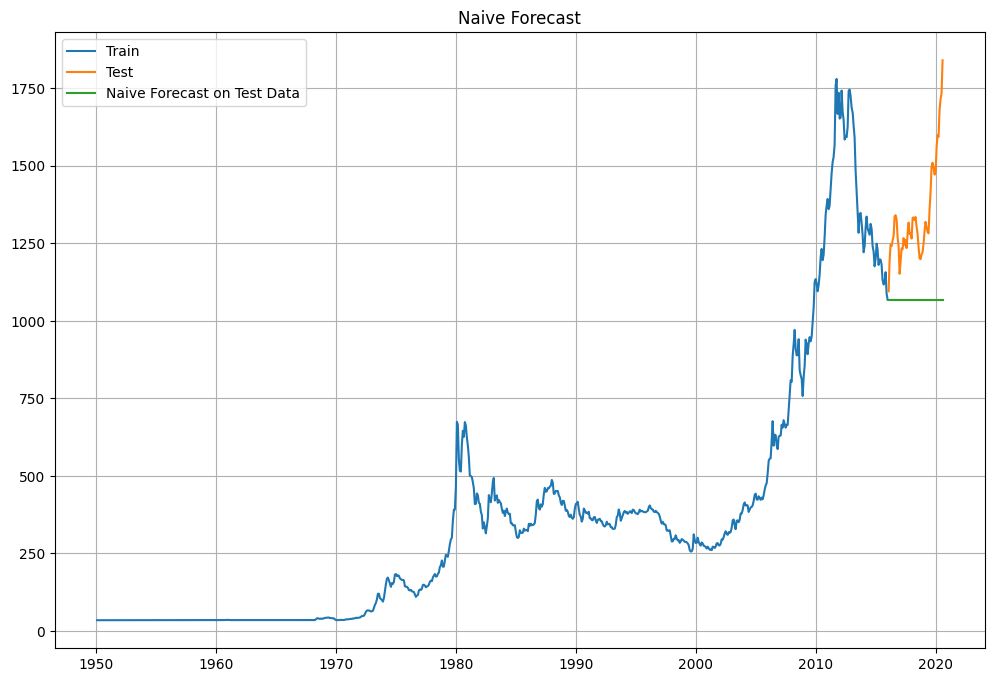

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(naive_train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(naive_test['naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid()

In [36]:
# MAPE model 2
model2_mape_test = mape(test['Price'].values, naive_test['naive'].values)
print("Naive Forecast on Test Data, MAPE = %3.3f" %(model2_mape_test), "%")

Naive Forecast on Test Data, MAPE = 19.380 %


In [37]:
df2_results = pd.DataFrame({'Test MAPE %': [model2_mape_test]}, index=['NaiveModel'])
results = pd.concat([results, df2_results])
results

,Test MAPE %
RegressionOnTime,29.76
NaiveModel,19.38


In [38]:
# Simple Average
simple_avg_train = train.copy()
simple_avg_test = test.copy()
simple_avg_test['mean_forecast'] = train['Price'].mean()
simple_avg_test.head()

,Price,mean_forecast
month,,
2016-01-31,1095.655,352.371841
2016-02-29,1194.893,352.371841
2016-03-31,1246.312,352.371841
2016-04-30,1241.452,352.371841
2016-05-31,1259.755,352.371841


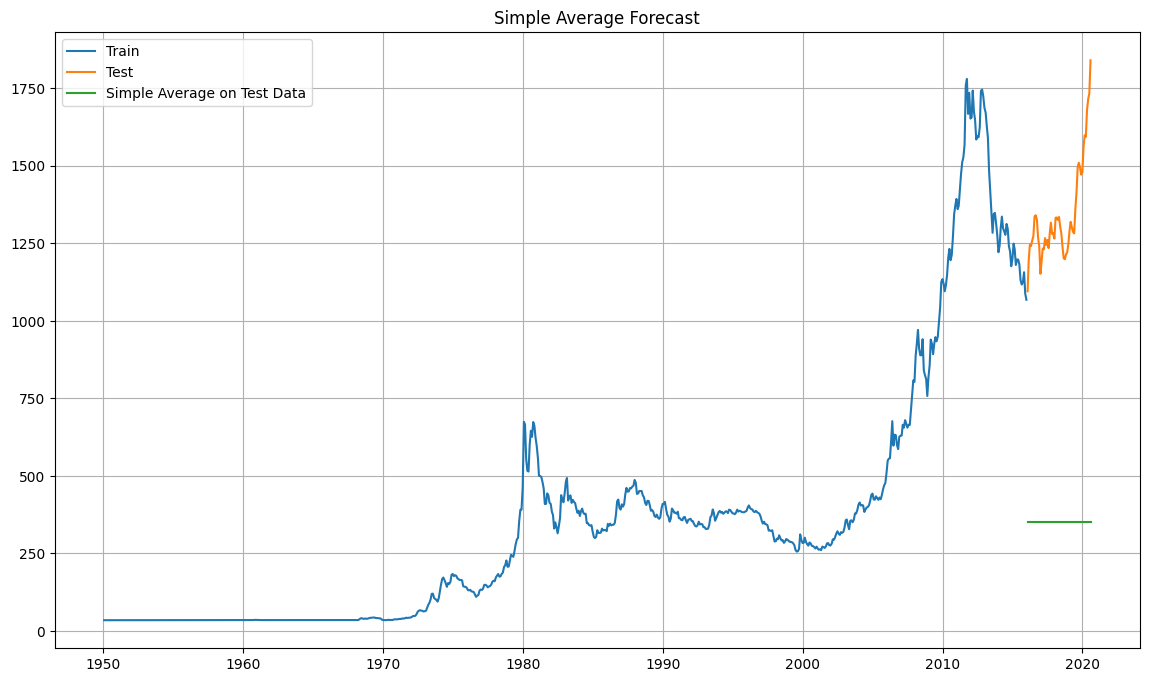

In [39]:
plt.figure(figsize = (14,8))
plt.plot(simple_avg_train['Price'], label="Train")
plt.plot(simple_avg_test['Price'], label="Test")
plt.plot(simple_avg_test['mean_forecast'], label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid()

In [40]:
# MAPE test data
model3_mape_test = mape(test['Price'].values, simple_avg_test['mean_forecast'].values)
print("Simple Average Forecast on the Test Data, MAPE = %3.3f" %(model3_mape_test), "%")

Simple Average Forecast on the Test Data, MAPE = 73.410 %


In [41]:
df3_results = pd.DataFrame({'Test MAPE %': [model3_mape_test]}, index=['SimpleAverageModel'])
results = pd.concat([results, df3_results])
results

,Test MAPE %
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41


In [42]:
# Moving Avg
move_avg = df.copy()
move_avg['Trailing_2'] = move_avg['Price'].rolling(2).mean()
move_avg['Trailing_3'] = move_avg['Price'].rolling(3).mean()
move_avg['Trailing_5'] = move_avg['Price'].rolling(4).mean()
move_avg['Trailing_7'] = move_avg['Price'].rolling(5).mean()
move_avg.head()

,Price,Trailing_2,Trailing_3,Trailing_5,Trailing_7
month,,,,,
1950-01-31,34.73,NaN,NaN,NaN,NaN
1950-02-28,34.73,34.73,NaN,NaN,NaN
1950-03-31,34.73,34.73,34.73,NaN,NaN
1950-04-30,34.73,34.73,34.73,34.73,NaN
1950-05-31,34.73,34.73,34.73,34.73,34.73


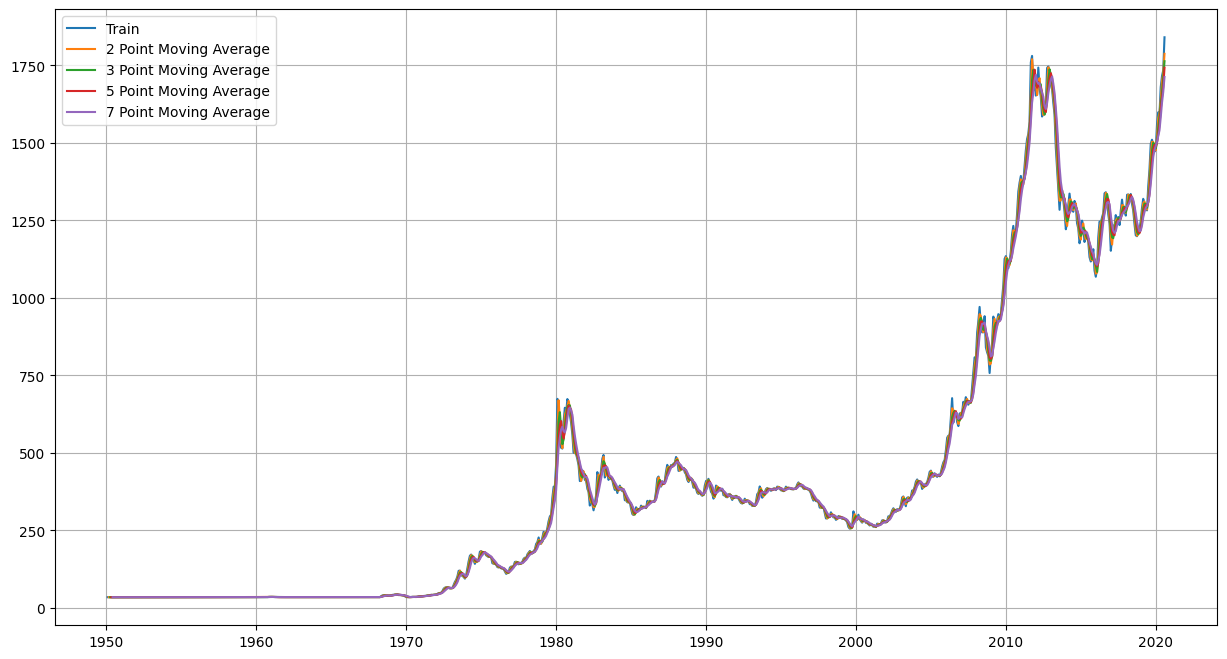

In [43]:
plt.figure(figsize=(15,8))
plt.plot(move_avg['Price'], label='Train')
plt.plot(move_avg['Trailing_2'], label='2 Point Moving Average')
plt.plot(move_avg['Trailing_3'], label='3 Point Moving Average')
plt.plot(move_avg['Trailing_5'], label='5 Point Moving Average')
plt.plot(move_avg['Trailing_7'], label='7 Point Moving Average')

plt.legend(loc = 'best')
plt.grid()

In [44]:
# generate train and test set
trailing_move_avg_train = move_avg[move_avg.index.year <= 2015]
trailing_move_avg_test = move_avg[move_avg.index.year > 2015]

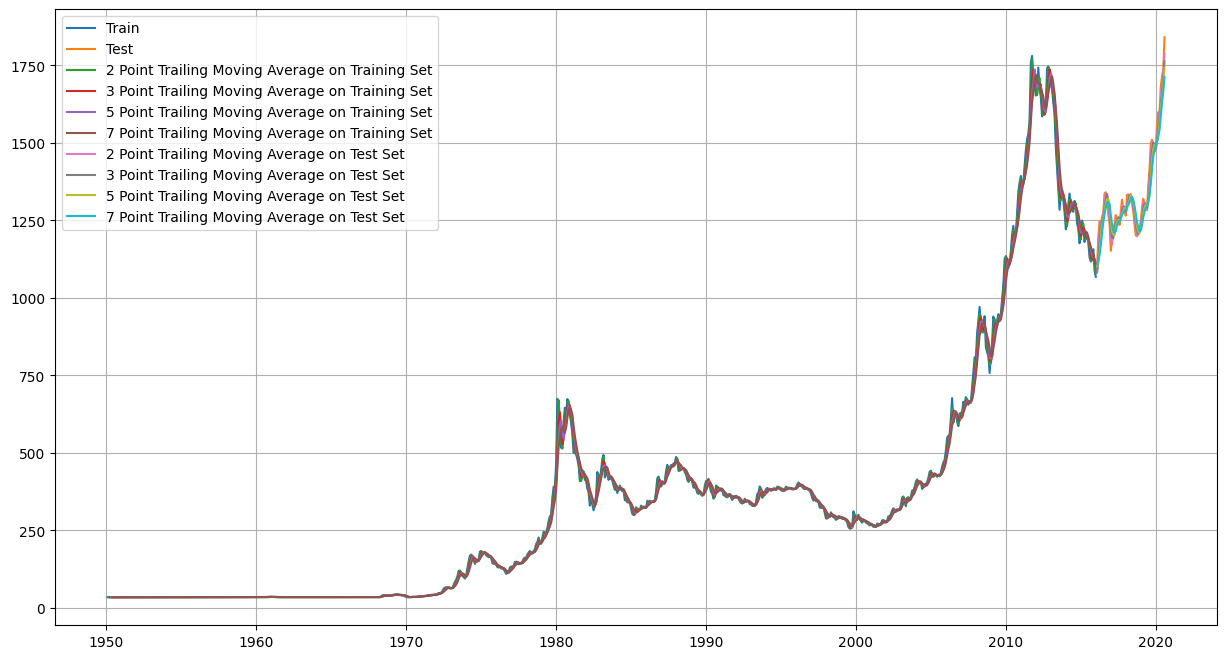

In [45]:
plt.figure(figsize=(15,8))
plt.plot(trailing_move_avg_train['Price'], label='Train')
plt.plot(trailing_move_avg_test['Price'], label='Test')

plt.plot(trailing_move_avg_train['Trailing_2'],label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_move_avg_train['Trailing_3'],label='3 Point Trailing Moving Average on Training Set')
plt.plot(trailing_move_avg_train['Trailing_5'],label = '5 Point Trailing Moving Average on Training Set')
plt.plot(trailing_move_avg_train['Trailing_7'],label = '7 Point Trailing Moving Average on Training Set')

plt.plot(trailing_move_avg_test['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_move_avg_test['Trailing_3'], label='3 Point Trailing Moving Average on Test Set')
plt.plot(trailing_move_avg_test['Trailing_5'],label = '5 Point Trailing Moving Average on Test Set')
plt.plot(trailing_move_avg_test['Trailing_7'],label = '7 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid()

In [46]:
## Test Data - MAPE --> 2 point Trailing MA

model4_mape_test2 = mape(test['Price'].values,trailing_move_avg_test['Trailing_2'].values)
print("For 2 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(model4_mape_test2),"%")

## Test Data - MAPE  --> 3 point Trailing MA

model4_mape_test3 = mape(test['Price'].values,trailing_move_avg_test['Trailing_3'].values)
print("For 3 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(model4_mape_test3),"%")

## Test Data - MAPE --> 5 point Trailing MA

model4_mape_test5 = mape(test['Price'].values,trailing_move_avg_test['Trailing_5'].values)
print("For 5 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(model4_mape_test5),"%")

## Test Data - MAPE  --> 7 point Trailing MA

model4_mape_test7 = mape(test['Price'].values,trailing_move_avg_test['Trailing_7'].values)
print("For 7 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f " %(model4_mape_test7),"%")

For 2 point Moving Average Model forecast on the Training Data,  MAPE is 1.230 %
For 3 point Moving Average Model forecast on the Training Data,  MAPE is 2.050 %
For 5 point Moving Average Model forecast on the Training Data,  MAPE is 2.770 %
For 7 point Moving Average Model forecast on the Training Data,  MAPE is 3.330  %


In [47]:
df4_results = pd.DataFrame({'Test MAPE (%)': [model4_mape_test2,model4_mape_test3
                                          ,model4_mape_test5,model4_mape_test7]}
                           ,index=['2pointTrailingMovingAverage','3pointTrailingMovingAverage'
                                   ,'5pointTrailingMovingAverage','7pointTrailingMovingAverage'])

results = pd.concat([results, df4_results])
results

,Test MAPE %,Test MAPE (%)
RegressionOnTime,29.76,NaN
NaiveModel,19.38,NaN
SimpleAverageModel,73.41,NaN
2pointTrailingMovingAverage,NaN,1.23
3pointTrailingMovingAverage,NaN,2.05
5pointTrailingMovingAverage,NaN,2.77
7pointTrailingMovingAverage,NaN,3.33


In [48]:
# simple exponential smoothing
ses_train = train.copy()
ses_test = test.copy()

In [50]:
ses_model = SimpleExpSmoothing(ses_train['Price'])
ses_model_fit = ses_model.fit(optimized=True)

In [51]:
ses_model_fit.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 34.73,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [52]:
ses_test['Predict'] = ses_model_fit.forecast(steps=len(test))
ses_test.head()

,Price,Predict
month,,
2016-01-31,1095.655,1068.419069
2016-02-29,1194.893,1068.419069
2016-03-31,1246.312,1068.419069
2016-04-30,1241.452,1068.419069
2016-05-31,1259.755,1068.419069


Text(0.5, 1.0, 'Alpha = 0.995 Predictions')

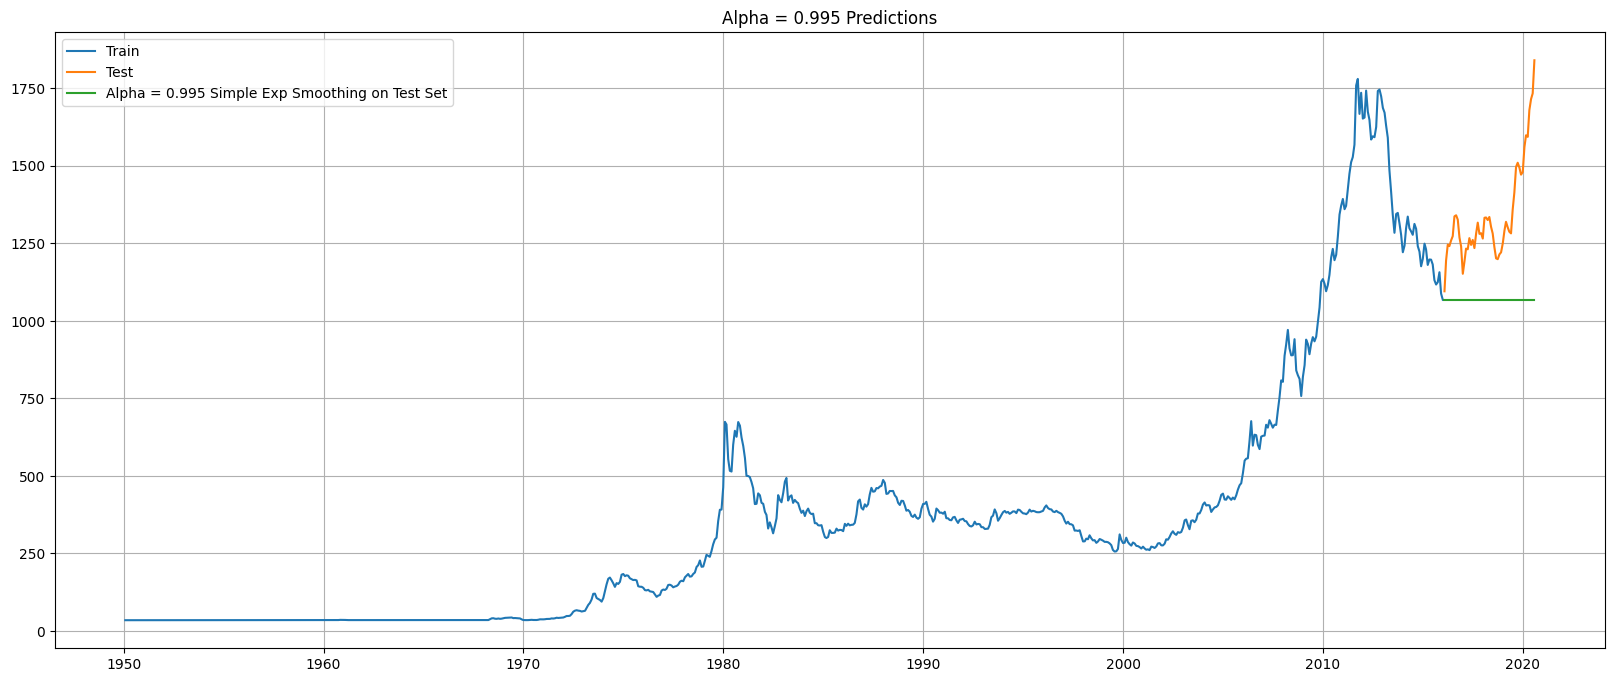

In [54]:
plt.figure(figsize=(20,8))
plt.plot(ses_train['Price'], label='Train')
plt.plot(ses_test['Price'], label='Test')
plt.plot(ses_test['Predict'], label='Alpha = 0.995 Simple Exp Smoothing on Test Set')
plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.995 Predictions')

In [56]:
# test data
model5_mape_test1 = mape(ses_test['Price'].values, ses_test['Predict'].values)
print("Mape = %3.3f Alpha = 0.995 Simple Exponential Smoothing Model on Test Data")

Mape = %3.3f Alpha = 0.995 Simple Exponential Smoothing Model on Test Data


In [60]:
df5_results = pd.DataFrame({'Test MAPE(%)' : [model5_mape_test1]}, index=['Alpha=0.995, SimpleExponentialSmoothing'])
results = pd.concat([results, df5_results])
results

,Test MAPE %,Test MAPE (%),Test MAPE(%)
RegressionOnTime,29.76,NaN,NaN
NaiveModel,19.38,NaN,NaN
SimpleAverageModel,73.41,NaN,NaN
2pointTrailingMovingAverage,NaN,1.23,NaN
3pointTrailingMovingAverage,NaN,2.05,NaN
5pointTrailingMovingAverage,NaN,2.77,NaN
7pointTrailingMovingAverage,NaN,3.33,NaN
"Alpha=0.995, SimpleExponentialSmoothing",NaN,NaN,19.38
"Alpha=0.995, SimpleExponentialSmoothing",NaN,NaN,19.38


In [61]:
df6_results = pd.DataFrame({'Alpha Values':[], 'Train MAPE':[], 'Test MAPE': []})